# **Using age, cholesterol and heart rate to classify heart disease patients from Cleveland.**
### Introduction:
The term heart (cardiovascular) disease describes a range of heart conditions that arise from problems with the heart and blood vessels. One of these is coronary artery disease, which is when the arteries supplying blood to the heart narrow. Many risk factors can increase the chance of developing this disease, including cholesterol levels and maximum heart rate.

High levels of cholesterol result in fatty deposits in blood vessels that clog them, making it difficult for enough blood to flow through the arteries. When these deposits break suddenly, they form a clot resulting in a heart attack or stroke. If a patient has clogged arteries, the maximum heart rate should increase to continue to pump enough blood.

The goal of this project will be to use these risk factors to classify patients based on likeliness to have heart disease.

The question we will be addressing is: **Is a new patient likely to have heart disease, based on age, cholesterol levels and maximum heart rate achieved?**

### Preliminary exploratory data analysis:
* ~~Demonstrate that the dataset can be read from the web into R ~~
* ~~Clean and wrangle your data into a tidy format~~
* Using **only training data**, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* ~~Using **only training data**, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.~~

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [11]:
set.seed(1)
# reading the dataframe from URL, assigning col names and types
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                           col_types = list("d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "f", "f", "d"))

# cleaning, wrangling data
cleveland_data[ cleveland_data == "?" ] <- NA

cleveland_clean <- cleveland_data %>%
                    mutate(diag = ifelse(is.na(num), NA, (num > 0))) %>%
                    mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
                           fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
                           exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
                           ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope)))

#splitting dataframe into training, testing datasets
cleveland_split <- initial_split(cleveland_clean, prop = 3/4, strata = num)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)

cleveland_summary <- cleveland_training %>%
                     group_by(diag) %>%
                     summarize(n = n())

cleveland_summary

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,2,2,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,1,2,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0,FALSE


`summarise()` ungrouping output (override with `.groups` argument)



diag,n
<lgl>,<int>
FALSE,123
TRUE,105


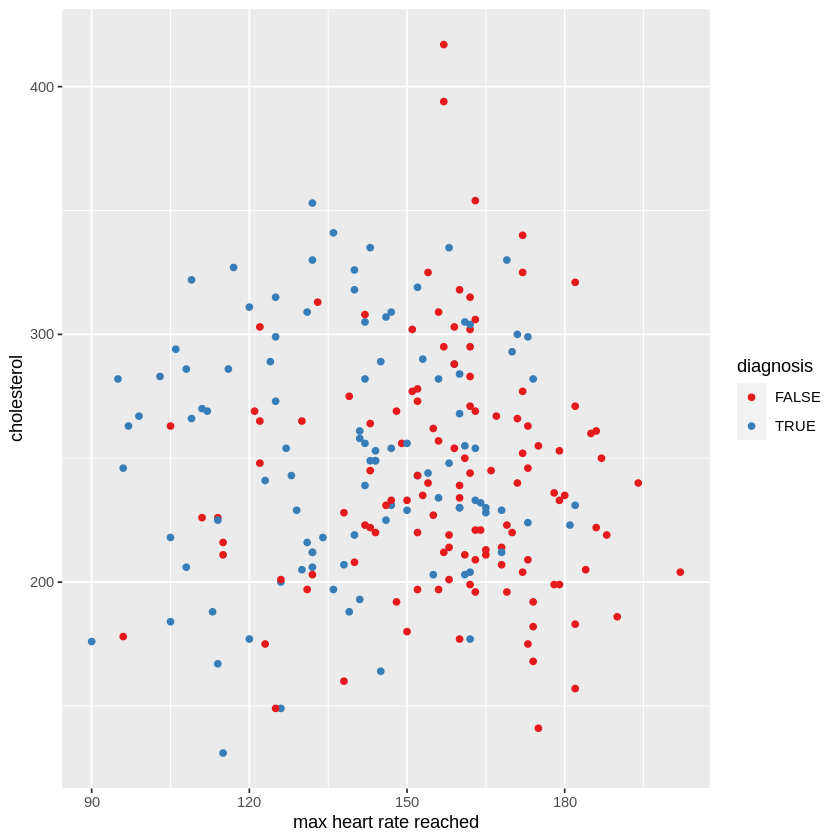

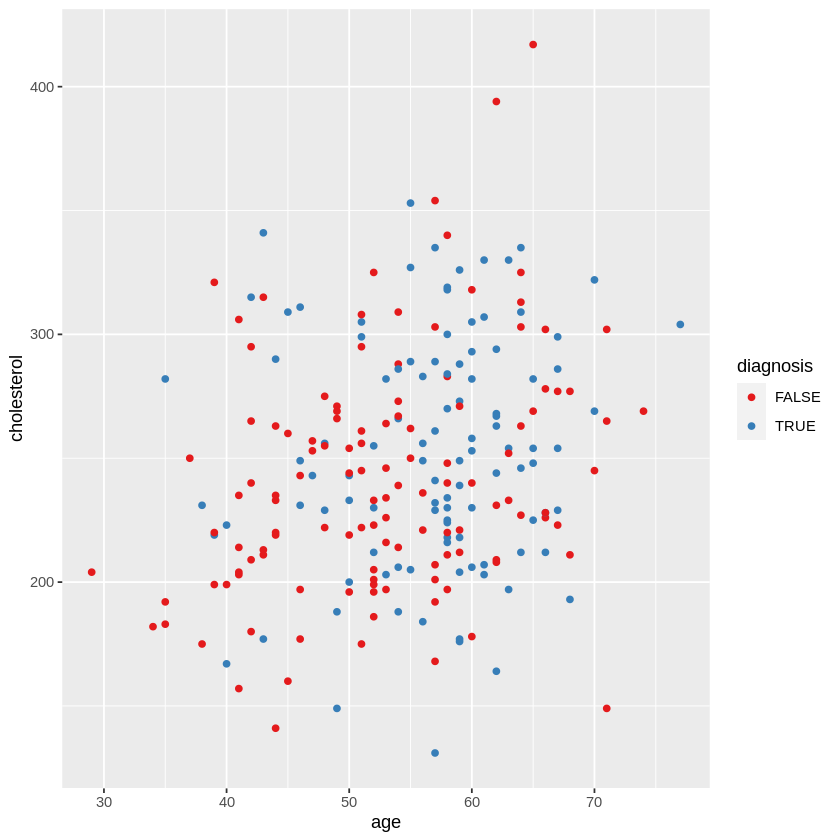

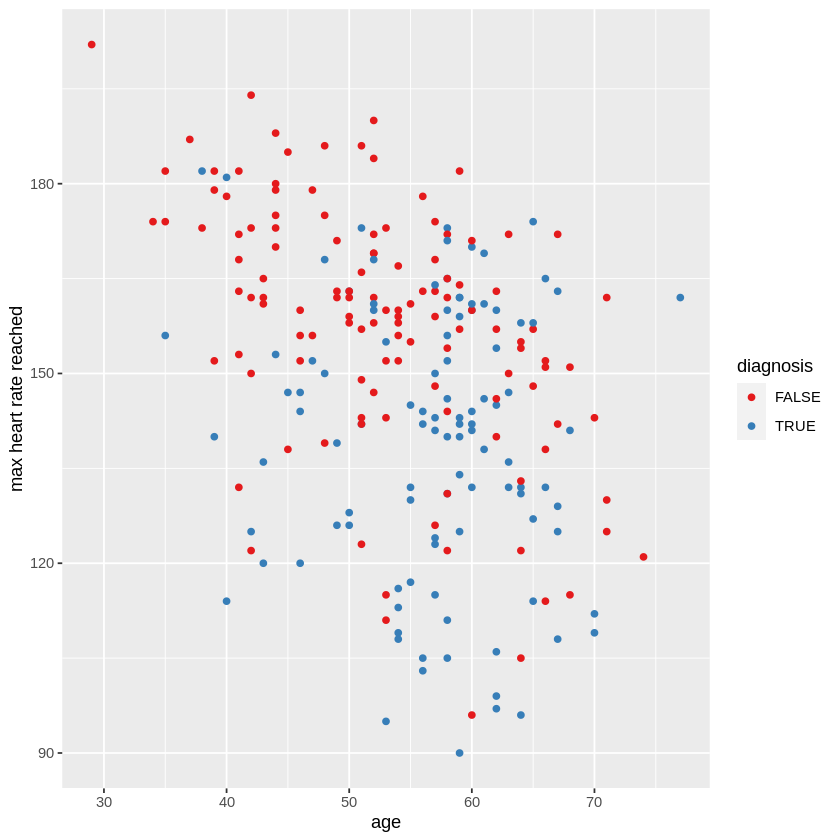

In [9]:
#plotting the training data
plot1 <- ggplot(cleveland_training, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "max heart rate reached", y = "cholesterol", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

plot2 <- ggplot(cleveland_training, aes(x = age, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "age", y = "cholesterol", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

plot3 <- ggplot(cleveland_training, aes(x = age, y = thalach, color = diag)) +
                 geom_point() +
                 labs(x = "age", y = "max heart rate reached", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

plot1
plot2
plot3

### Methods:
We are using the processed.cleveland.data from the Heart Disease Database (originally collected from the Cleveland Clinic Foundation) to predict if a patient from Cleveland will have heart disease. The columns are as follows:
1. **age**: age
2. **sex**: sex (1 = male, 0 = female)
3. **cp**: chest pain type
4. **trestbps**: resting blood pressure in mmHg
5. **chol**: serum cholestoral in mg/dl
6. **fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
7. **restecg**: resting electrocardiographic results
8. **thalach**: maximum heart rate achieved
9. **exang**: whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak**: ST depression induced by exercise, relative to rest
11. **slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. **ca**: number of major vessels (0-3) colored by flourosopy
13. **thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)

Each column is numeric-valued and there are 303 rows, with missing data represented as the string "?".

To clean the data, we changed all "?" values into NA. Since **num** uses integers to distinguish presence (1,2,3,4) from absence (0), and we want to determine *whether or not* a patient has heart disease, a new boolean column **diag** has been appended to narrow diagnoses down to TRUE or FALSE.

We used initial_split() to split our dataframe into 75% training and 25% testing data, stratifying for **diag**. We used only the training set for analysis.

To visualize relationships in our data, we generated scatter plots of different numerical (non-factor) variables against eachother. This helped us identify the best predictors to use, which eneded up aligning with our initial research (see introduction). When plotting **chol** vs **thalach**, and coloring our points based on **diag**, we could see three clear regions of TRUE diagnoses, FALSE diagnoses and an region of mixing of the two. Similarly distinct distributions were seen when visualizing **age** vs **chol** and **age** vs **thalach**.

Therefore, we have decided to make **age**, **chol** and **thalach** our predictors.

To summarize our data, we grouped by **diag** then summarized the number of instances of each diagnosis to ensure no one class was overrepresented in the training set. This is to avoid any skewing in our predictor model later on in the project.

### Expected outcomes and significance:
We expect to find that a patient prone to heart disease will tend to have higher levels of cholesterol and higher maximum heart rates. 

Being able to have a classification system for heart disease could make it easier and more accurate for doctors to diagnose patients, resulting in earlier treatment.

Some future questions this could lead to are:
1. Which factor or the two contributes the most to heart disease?
2. What measures can be taken to prevent heart disease?